In [14]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage
from tensorflow.keras import layers
import tensorflow as tf

In [15]:
print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
Keras: 2.4.3
OpenCV: 4.4.0
NumPy: 1.18.5
Matplotlib: 3.3.2
Scikit-Image: 0.17.2


In [16]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from tensorflow.keras import layers
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os
import random
import PIL
import sewar

In [17]:
# python magic function, displays pyplot figures in the notebook
#%matplotlib inline
# define a function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

In [18]:
# define function for mean squared error (MSE)
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

In [19]:
# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(sewar.psnr(target, ref))
    scores.append(sewar.psnrb(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    scores.append(sewar.msssim(target, ref))
    scores.append(sewar.uqi(target, ref))
    
    return scores

In [20]:
def prepare_images(path, factor):
    

    for file in os.listdir(path):

        img = cv2.imread(path + '/' + file)
        print(path + '/' + file)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

        h, w, _ = img.shape
        new_height = h // factor
        new_width = w // factor

        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        img=cv2.cvtColor(img, cv2.COLOR_YUV2BGR)

        print('Saving {}'.format(file))
        cv2.imwrite(os.getcwd()+'/Image/{}'.format(file), img)

In [21]:
def modcrop(img, scale):
    tmpsz = img.shape
    
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 0:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [22]:
def model_ESPCNN(upscale_factor=2, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return keras.Model(inputs, outputs)

In [23]:
# load the srcnn model with weights
espcnn = model_ESPCNN()
optimizer = Adam(learning_rate=0.001)

espcnn.compile(optimizer=optimizer, loss="mean_squared_error")
espcnn.load_weights(os.getcwd()+'\\espcnn weights\\trained_espcnn.h5')

In [24]:
def predict_ESPCNN(image_path):

    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread(os.getcwd()+'\\Set14\\{}'.format(file))
    print(np.shape(degraded))
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YUV)
    
    y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    y[0,:,:,0]=temp[:, :, 0].astype(float) / 255
    
    np.expand_dims(y, axis=0)
    pre = espcnn.predict(y)
    
    
    print("came here{}".format(np.shape(pre)))
    pre=pre[0]
   # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    pre=pre.reshape((np.shape(pre)[0],np.shape(pre)[1]))
    # copy Y channel back to image and convert to BGR
    temp1=np.zeros((pre.shape[0],pre.shape[1],3),dtype=float)
    temp1[:, :, 0] = pre[:, :]
    
    temp1[:,:,1]=cv2.resize(temp[:,:,1], (pre.shape[1], pre.shape[0]), interpolation = cv2.INTER_LINEAR)
    temp1[:,:,2]=cv2.resize(temp[:,:,2], (pre.shape[1], pre.shape[0]), interpolation = cv2.INTER_LINEAR)
    print(np.shape(temp1))
    temp1=np.uint8(temp1)

    output = cv2.cvtColor(temp1, cv2.COLOR_YUV2BGR)


    degraded_scaled=cv2.resize(degraded,(ref.shape[1], ref.shape[0]))

    scores=[]
    scores.append(compare_images(ref,degraded_scaled))
    scores.append(compare_images(ref,cv2.resize(output,(ref.shape[1], ref.shape[0]))))
    
    return ref, degraded, output ,scores 

In [25]:
factor = 10

psnr_v = [0] * (factor-2)
psnrb_v = [0] * (factor-2)
mse_v = [0] * (factor-2)
ssim_v = [0] * (factor-2)
msssim_v = [0] * (factor-2)
uqi_v = [0] * (factor-2)

for i in range(2, factor):
    prepare_images(os.getcwd()+'/Set14', i)
    for filename in os.listdir('.\\Image'):
        print("***********" + filename + "*************")
        ref, degraded, output,scores = predict_ESPCNN(os.getcwd()+'\\Image\\' + filename)
        psnr_v[i-2] += scores[1][0]
        psnrb_v[i-2] += scores[1][1]
        mse_v[i-2] += scores[1][2]
        ssim_v[i-2] += scores[1][3]
        msssim_v[i-2] += scores[1][4]
        uqi_v[i-2] += scores[1][5]
x = [2, 3, 4, 5, 6, 7, 8, 9]

sers\Taj\Documents\257\Project-257/Set14/ppt3.bmp
Saving ppt3.bmp
c:\Users\Taj\Documents\257\Project-257/Set14/SFO.bmp
Saving SFO.bmp
c:\Users\Taj\Documents\257\Project-257/Set14/sikkim.bmp
Saving sikkim.bmp
***********baboon.bmp*************
(160, 166, 3)
came here(1, 320, 332, 1)
(320, 332, 3)
***********barbara.bmp*************
(192, 240, 3)
came here(1, 384, 480, 1)
(384, 480, 3)
***********bridge.bmp*************
(170, 170, 3)
came here(1, 340, 340, 1)
(340, 340, 3)
***********coastguard.bmp*************
(96, 117, 3)
came here(1, 192, 234, 1)
(192, 234, 3)
***********comic.bmp*************
(120, 83, 3)
came here(1, 240, 166, 1)
(240, 166, 3)
***********face.bmp*************
(92, 92, 3)
came here(1, 184, 184, 1)
(184, 184, 3)
***********flowers.bmp*************
(120, 166, 3)
came here(1, 240, 332, 1)
(240, 332, 3)
***********foreman.bmp*************
(96, 117, 3)
came here(1, 192, 234, 1)
(192, 234, 3)
***********image-1.bmp*************
(81, 69, 3)
came here(1, 162, 138, 1)
(162, 1

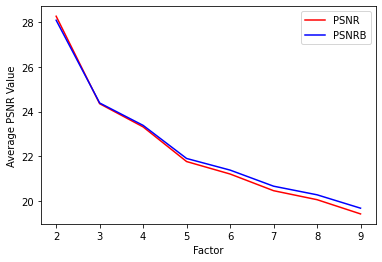

In [31]:
file_num = len(os.listdir('.\\Image'))
plt.plot(x, np.divide(psnr_v, file_num), '-r', label='PSNR')
plt.plot(x, np.divide(psnrb_v, file_num), '-b', label='PSNRB')
plt.xlabel('Factor')
plt.ylabel('Average PSNR Value')
plt.legend()
plt.show()
plt.close()

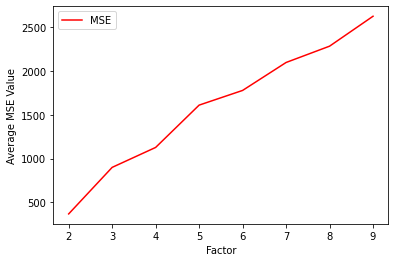

In [27]:
file_num = len(os.listdir('.\\Image'))
plt.plot(x, np.divide(mse_v, file_num), '-r', label='MSE')
plt.xlabel('Factor')
plt.ylabel('Average MSE Value')
plt.legend()
plt.show()
plt.close()

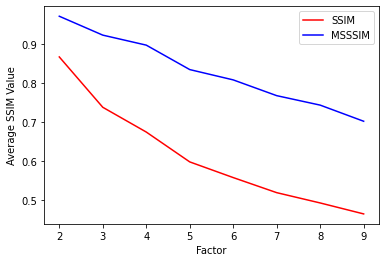

In [28]:
file_num = len(os.listdir('.\\Image'))
plt.plot(x, np.divide(ssim_v, file_num), '-r', label='SSIM')
plt.plot(x, np.divide(msssim_v, file_num), '-b', label='MSSSIM')
plt.xlabel('Factor')
plt.ylabel('Average SSIM Value')
plt.legend()
plt.show()
plt.close()

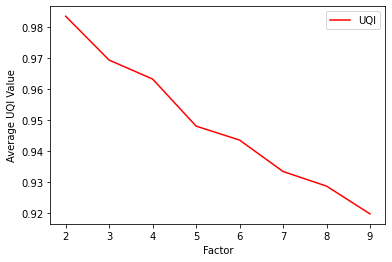

In [29]:
file_num = len(os.listdir('.\\Image'))
plt.plot(x, np.divide(uqi_v, file_num), '-r', label='UQI')
plt.xlabel('Factor')
plt.ylabel('Average UQI Value')
plt.legend()
plt.show()
plt.close()

In [30]:
print(uqi_v)
print(file_num)

[18.68462969117997, 18.41624762415609, 18.300577543573812, 18.01263450903767, 17.927193992340023, 17.734965907497156, 17.645781291500587, 17.4756687263878]
19
